<a href="https://colab.research.google.com/github/hoangviet-nguyen/bveri-abschluss-projekt/blob/main/projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

try:
    import jupyter_black

    jupyter_black.load()
except:
    print("black not installed")

black not installed


# Projekt: Under Water Image Segmentation

In [2]:
import os
from pathlib import Path
import suim_set
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.v2 import functional as TF
import torch
import torchshow as ts
from torch.utils.data import Dataset
from typing import Callable
import torchinfo
from torch import nn
from torch.nn import functional as F

ModuleNotFoundError: No module named 'suim_set'

## Download dataset: SUIM dataset

In [ ]:
DATA_PATH = Path("./workspace/code/data")

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)
    suim_set.download(DATA_PATH)

Downloading...
From (original): https://drive.google.com/uc?id=1hsTc6XeL59WDQIj0EOMZXdtT-Af0RcOg
From (redirected): https://drive.google.com/uc?id=1hsTc6XeL59WDQIj0EOMZXdtT-Af0RcOg&confirm=t&uuid=d34ccf34-f391-43c5-9847-e18826f41ff3
To: c:\Users\viety\OneDrive\Desktop\Studium\5.Semester\bverl\bevri-abschluss-projekt\workspace\code\data\train_val.zip
100%|██████████| 172M/172M [00:08<00:00, 20.4MB/s] 


File downloaded and saved to workspace\code\data\train_val.zip
Starting to extract... workspace\code\data\train_val
File extracted to workspace\code\data\train_val


Downloading...
From: https://drive.google.com/uc?id=1YZBFO_tEmP5aImfrH01nDu4Kg1wtvklX
To: c:\Users\viety\OneDrive\Desktop\Studium\5.Semester\bverl\bevri-abschluss-projekt\workspace\code\data\TEST.zip
100%|██████████| 12.8M/12.8M [00:00<00:00, 20.8MB/s]


File downloaded and saved to workspace\code\data\TEST.zip
Starting to extract... workspace\code\data\TEST
File extracted to workspace\code\data\TEST


## Data Inspection

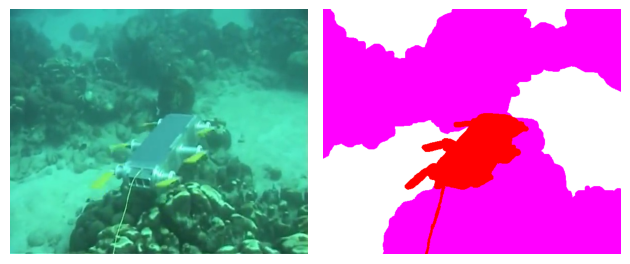

In [ ]:
root_path = DATA_PATH.joinpath("train_val/train_val")
norm_img = Image.open(root_path.joinpath("images/d_r_1_.jpg"))
norm_img = np.array(norm_img)

label_img = Image.open(root_path.joinpath("masks/d_r_1_.bmp"))
label_img = np.array(label_img) / 255
imgs = [norm_img, label_img]

fig, axs = plt.subplots(ncols=2)
for img, ax in zip(imgs, axs.flatten()):
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show();

In [ ]:
# Define the mapping dictionary
rgb_to_class = {
    (0, 0, 0): 0,  # Black - Background waterbody
    (0, 0, 255): 1,  # Blue - Human divers
    (0, 255, 0): 2,  # Green - Plants/sea-grass
    (0, 255, 255): 3,  # Sky blue - Wrecks/ruins
    (255, 0, 0): 4,  # Red - Robots/instruments
    (255, 0, 255): 5,  # Pink - Reefs/invertebrates
    (255, 255, 0): 6,  # Yellow - Fish and vertebrates
    (255, 255, 255): 7,  # White - Sea-floor and rocks
}


labels = np.zeros(label_img.shape[:2], dtype=np.int64)

for rgb, class_idx in rgb_to_class.items():
    x, y, _ = np.where(label_img == np.array(rgb))
    labels[x, y] = class_idx

labels = torch.tensor(labels)
labels.shape

torch.Size([480, 584])

## Building a dataset

In [ ]:
class SuimDataSet(Dataset):
    def __init__(
        self,
        root_path: Path,
        transform_images: Callable = None,
        transform_labels: Callable = None,
    ):
        """
        Initializes the dataset.

        Args:
            root_path (Path): Path to the dataset directory.
            transform_images (callable, optional): Transformation function for images.
            transform_labels (callable, optional): Transformation function for labels.
        """

        self.root_path = root_path
        self.transform_images = transform_images
        self.transform_labels = transform_labels
        self.image_paths = list((root_path / "images").glob("*.jpg"))

        self.rgb_to_class = {
            (0, 0, 0): 0,  # Black - Background waterbody
            (0, 0, 255): 1,  # Blue - Human divers
            (0, 255, 0): 2,  # Green - Plants/sea-grass
            (0, 255, 255): 3,  # Sky blue - Wrecks/ruins
            (255, 0, 0): 4,  # Red - Robots/instruments
            (255, 0, 255): 5,  # Pink - Reefs/invertebrates
            (255, 255, 0): 6,  # Yellow - Fish and vertebrates
            (255, 255, 255): 7,  # White - Sea-floor and rocks
        }

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(
        self, idx: int
    ) -> tuple[torch.Tensor | Image.Image, torch.Tensor, torch.Tensor]:
        """
        Retrieves the image and corresponding label masks for a given index.

        Args:
            idx (int): The index of the item to retrieve.

        Returns:
            tuple: A tuple containing:
                - image (torch.Tensor | Image.Image): The transformed image or original image.
                - label_masks (torch.Tensor): A binary mask tensor of shape (K, H, W) where K is the number of classes.
                  Each channel represents the binary mask for a specific class.
                - labels_tensor (torch.Tensor): A segmentation map tensor of shape (1, H, W) indicating class indices
                for each pixel.
        """
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        label_path = self.root_path / f"masks/{image_path.stem}.bmp"
        label_img = np.array(Image.open(label_path)) / 255
        labels = np.zeros(label_img.shape[:2], dtype=np.int64)

        for rgb, class_idx in self.rgb_to_class.items():
            x, y, _ = np.where(label_img == np.array(rgb))
            labels[x, y] = class_idx

        labels_tensor = torch.tensor(labels).unsqueeze(0)
        label_masks = torch.zeros(len(self.rgb_to_class), *labels.shape).scatter_(
            0, labels_tensor, 1
        )

        if self.transform_images:
            image = self.transform_images(image)
        if self.transform_labels:
            label_masks = self.transform_labels(label_masks)
            labels_tensor = self.transform_labels(labels_tensor)

        return image, label_masks, labels_tensor

In [ ]:
train_path = DATA_PATH.joinpath("train_val/train_val")
test_path = DATA_PATH.joinpath("TEST/TEST")

ds_train = SuimDataSet(root_path=train_path)
ds_test = SuimDataSet(root_path=test_path)

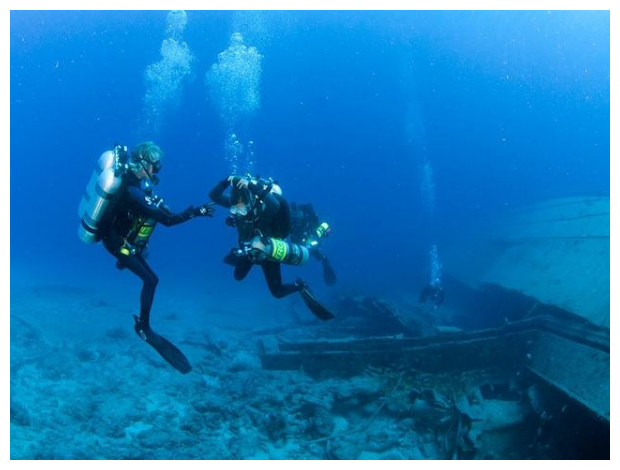

In [ ]:
observation, label_masks, label_tensor = ds_train[0]
ts.show([observation, label_masks])

## Fully-Convolutional Network

### Encoder Block

In [ ]:
class EncoderBlock(nn.Module):
    """A basic encoder block that performs convolution, normalization, and activation."""

    def __init__(
        self,
        in_channels: int,
        out_channels: list[int],
        kernel_size=(3, 3),
        padding=1,
        skip=True,
    ):
        super().__init__()
        self.skip = skip

        f1, f2, f3, f4 = out_channels

        self.conv1 = nn.Conv2d(in_channels, f1, kernel_size=(1, 1), stride=1)
        self.bn1 = nn.BatchNorm2d(f1)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(f1, f2, kernel_size, padding=1)
        self.bn2 = nn.BatchNorm2d(f2)

        self.conv3 = nn.Conv2d(f2, f3, kernel_size=(1, 1))
        self.bn3 = nn.BatchNorm2d(f3)

        self.conv4 = nn.Conv2d(f1, f4, kernel_size=(1, 1))
        self.bn4 = nn.BatchNorm2d(f4)

    def forward(self, input_tensor):
        x = input_tensor

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.skip:
            shortcut = input_tensor
        else:
            shortcut = self.conv4(input_tensor)
            shortcut = self.bn4(shortcut)
        x += shortcut
        x = self.relu(x)
        return x

In [ ]:
class Encoder(nn.Module):
    """Encodes an image to a low-dimensional representation.

    Args:
        num_channels_in (int): Number of input channels (e.g., 3 for RGB images).
        num_channels (list[int]): Number of output channels for each block.
            Each block reduces spatial dimensionality by half.
    Input:
        image batch of shape (N, C, H, W)

    Output:
        image batch of shape (N, C2, H / S, W / S), where S is the global stride.
    """

    def __init__(self):
        super().__init__()

        self.initial_conv = nn.Conv2d(3, 64, kernel_size=(5, 5), stride=1, padding=2)
        self.initial_bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        self.block2 = nn.ModuleList(
            [
                EncoderBlock(64, [64, 64, 128, 128], skip=False),
                EncoderBlock(128, [64, 64, 128, 128], skip=True),
            ]
        )

        self.block3 = nn.ModuleList(
            [
                EncoderBlock(128, [128, 128, 256, 256], skip=False),
                EncoderBlock(256, [128, 128, 256, 256], skip=True),
                EncoderBlock(256, [128, 128, 256, 256], skip=True),
            ]
        )

    def forward(self, x):

        x = self.initial_conv(x)
        x = self.initial_bn(x)
        x = self.relu(x)

        encoded1 = x

        for encoder_block in self.block2:
            x = encoder_block(x)

        encoded2 = x

        for encoder_block in self.block3:
            x = encoder_block(x)

        encoded3 = x

        return [encoded1, encoded2, encoded3]

### Decoder Block

In [ ]:
class Decoder(nn.Module):
    """Decodes a low-dimensional representation back to an image.

    Args:
        num_channels_in (int): Number of input channels (output of encoder)
        num_channels (list[int]): Number of channels for each block, reversed from the encoder configuration.
    Input:
        feature map of shape (N, C, H, W)
    Output:
        image batch of shape (N, C_out, H_out, W_out), where C_out is typically the original input channels.
    """

    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes

        self.deconv1 = nn.ConvTranspose2d(
            256, 256, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.deconv2 = nn.ConvTranspose2d(
            128, 128, kernel_size=3, stride=2, padding=1, output_padding=1
        )

        # Convolutions for feature refinement
        self.conv1 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

        # Final output transposed convolution
        self.final_conv = nn.Conv2d(128, n_classes, kernel_size=3, stride=1, padding=1)

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(256)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(128)

    def concat_skip(
        self,
        layer_input,
        skip_input,
        in_channels,
        out_channels,
        kernel_size=3,
        padding=1,
    ):
        conv = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size, padding=padding
        )
        bn = nn.BatchNorm2d(out_channels)
        u = conv(layer_input)
        u = bn(u)

        if layer_input.size()[2:] != skip_input.size()[2:]:
            skip_input = F.interpolate(
                skip_input, size=layer_input.size()[2:], mode="nearest"
            )

        concatenated = torch.cat((u, skip_input), dim=1)

        return concatenated

    def forward(self, encoded_inputs):
        encoded1, encoded2, encoded3 = encoded_inputs
        decoded1 = self.conv1(encoded3)
        decoded1 = self.bn1(decoded1)
        decoded1 = F.interpolate(decoded1, scale_factor=2, mode="nearest")
        decoded1_final = self.concat_skip(encoded2, decoded1, 128, 256)

        decoded2_a = self.conv2(decoded1_final)
        decoded2_a = self.bn2(decoded2_a)
        decoded2_a = self.deconv1(decoded2_a)

        decoded2_b = self.conv3(decoded2_a)
        decoded2_b = self.bn3(decoded2_b)
        decoded2_b = self.deconv2(decoded2_b)
        decoded2_b = self.concat_skip(encoded1, decoded2_b, 64, 128)

        decoded3 = self.conv4(decoded2_b)
        decoded3 = self.bn4(decoded3)
        out = self.final_conv(decoded3)

        return out

### Encoder / Decoder

In [ ]:
class EncoderDecoder(nn.Module):
    """Encoder-Decoder architecture for image-to-image tasks.
    Args:
        encoder (nn.Module): The encoder network that reduces the
            spatial dimensions and extracts features from the input.
        decoder (nn.Module): The decoder network that upsamples the
            features and reconstructs the output image.
        num_in_channels (int): Number of input channels (e.g., 3 for RGB images).
        num_in_encoder_channels (int): Number of channels for the input
            convolution layer, used to match the encoder's initial channel size.
        num_out_decoder_channels (int): Number of channels for the final
            output from the decoder before the output layer.
        num_output_channels (int): Number of output channels (e.g., 1 for grayscale or
            3 for RGB).

    Input:
        x (torch.Tensor): Image batch of shape (N, num_in_channels, H, W).

    Output:
        torch.Tensor: Processed image batch of shape (N, num_output_channels, H, W).
    """

    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded_inputs = self.encoder(x)
        out = self.decoder(encoded_inputs)
        return out

In [ ]:
encoder = Encoder()
decoder = Decoder(n_classes=8)
net = EncoderDecoder(encoder=encoder, decoder=decoder)
print(torchinfo.summary(net, input_size=(1, 3, 320, 240)))

## Model Metrics

## Suim-Net Model

## Model Comparison